<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Artificial Neurons and Neural Networks

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

data.data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Artificial Neuron 1: The Perceptron

In [12]:
class Perceptron:
    
    def __init__(self,eta=0.01,n_iter=100,random_state=0):
        self.eta=eta # Learning rate
        self.n_iter=n_iter # Number of epochs
        self.random_state=random_state
        self.cost_path=[] #Keep track of cost for each iteration of training
    
    def fit(self,X,y):
        # Initialize the bias (weights[0]) and weights (weights[1:]) to small random numbers
        rgen=np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0,scale=0.01,size=(1+X.shape[1]))
        
        # Train the perceptron using stochastic gradient descent
        for i in range(self.n_iter):
            # Keep track of cost for each iteration
            cost_total = 0
            # Stochastic gradient descent
            for xi,yi in zip(X,y):
                # Get prediction
                yhat = self.predict(xi)
                # Calculate cost function - SSE
                error = yi-yhat
                cost = 0.5*(error)**2
                # Gradient of cost with respect to weights
                gradient_weights = error*-xi
                # Gradient of cost with respect to bias
                gradient_bias = error*-1
                # Calculate amount to update weights and bias
                delta_weights = self.eta * gradient_weights
                delta_bias = self.eta * gradient_bias
                # Update the weights
                self.weights[1:] -= delta_weights
                # Update bias
                self.weights[0] -= delta_bias
                # Count errors
                cost_total+= cost
            self.cost_path.append(cost_total)
        return self
    
    def predict(self,X):
        z = np.dot(X,self.weights[1:]) + self.weights[0]
        if z >= 0.0:
            yhat = 1
        else:
            yhat = 0
        return yhat

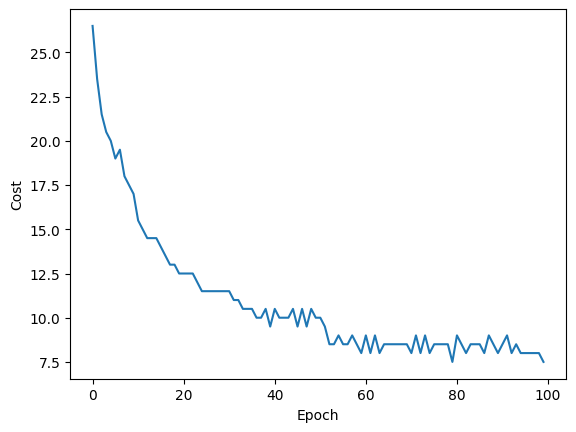

In [13]:
# Train the model and plot the cost
perceptron_model = Perceptron(eta=0.00001,n_iter=100)
perceptron_model.fit(X_train_scaled,y_train)
plt.plot(range(len(perceptron_model.cost_path)),perceptron_model.cost_path)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [14]:
# Calculate the test set performance
test_preds = []
for x in X_test_scaled:
    pred = perceptron_model.predict(x)
    test_preds.append(pred)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.947


## Artificial Neuron 2: Adaline

In [15]:
class Adaline:
    
    def __init__(self,eta=0.01,n_iter=100,random_state=0):
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
        self.cost_path=[]
    
    def fit(self,X,y):
        # Initialize the weights and bias (weights[0]) to small random numbers
        rgen=np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0,scale=0.01,size=(1+X.shape[1]))
        
        # Train adaline using batch gradient descent
        for i in range(self.n_iter):
            yhat = self.predict(X)
            # Calculate the cost function
            cost = np.sum(0.5 * (y-yhat)**2)
            # Gradient of cost with respect to weights
            gradient_weights = (y-yhat).T.dot(-X)
            # Gradient of cost with respect to bias
            gradient_bias = -np.sum(y-yhat)
            # Update weights and bias
            delta_weights = self.eta * gradient_weights
            delta_bias = self.eta * gradient_bias
            self.weights[1:] -= delta_weights
            self.weights[0] -= delta_bias
            # Add cost to total cost counter
            self.cost_path.append(cost)
        return self
    
    def predict(self,X):
        z = np.dot(X,self.weights[1:]) + self.weights[0]
        yhat = 1*z
        return yhat

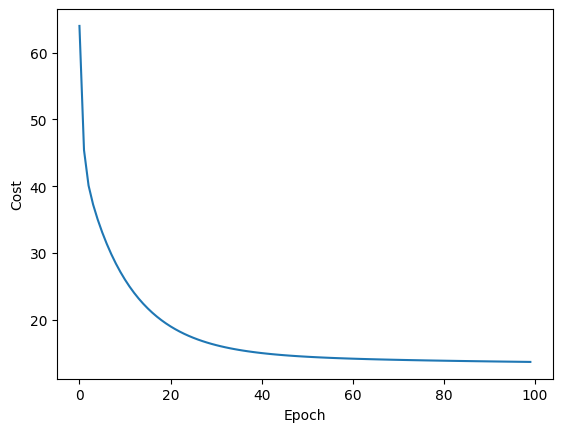

In [16]:
adaline_model = Adaline(eta=0.0001,n_iter=100)
adaline_model.fit(X_train_scaled,y_train)
plt.plot(range(len(adaline_model.cost_path)),adaline_model.cost_path)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [17]:
test_preds = adaline_model.predict(X_test_scaled)
test_preds = np.round(test_preds)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.921


## Multilayer Perceptron (MLP) with Scikit Learn

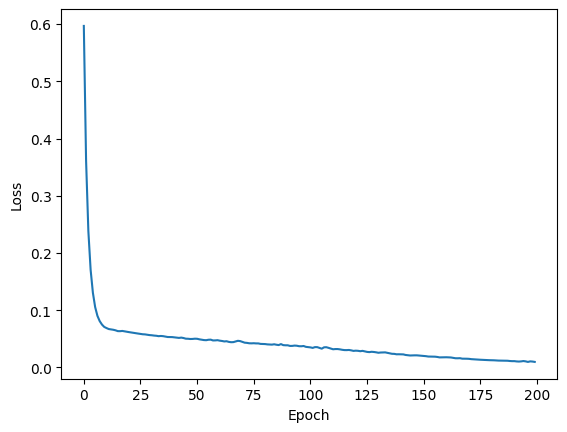

In [18]:
# Let's use SKLearn's MLP algorithm to demonstrate a neural network
# We will start with a shallow network
mlp_model = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic',learning_rate_init=0.01,random_state=0)
mlp_model.fit(X_train_scaled,y_train)

# Let's plot the loss curve on the training set
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# Compute the test set accuracy
test_preds = mlp_model.predict(X_test_scaled)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.982


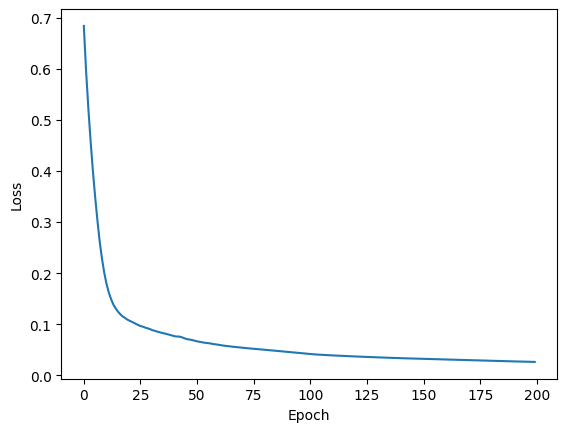

In [20]:
# Let's try a deeper network and use a relu activation function
mlp_model_deep = MLPClassifier(hidden_layer_sizes=(100,50,20,10),activation='relu',learning_rate_init=0.001,
                               max_iter=200,alpha=0.1,random_state=0)
mlp_model_deep.fit(X_train_scaled,y_train)

# Let's plot the loss curve on the training set
plt.plot(mlp_model_deep.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
test_preds = mlp_model_deep.predict(X_test_scaled)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.974
